In [9]:
import glob
import numpy as np
import json
from pycocotools.coco import COCO
import cv2
from matplotlib import pyplot as plt

from tqdm import tqdm

In [2]:
plt.rcParams['figure.figsize'] = [15, 8]

In [3]:
train_salicon_coco = COCO('../../data/salicon_coco/salicon_train_coco.json')
val_salicon_coco = COCO('../../data/salicon_coco/salicon_val_coco.json')

loading annotations into memory...
Done (t=2.64s)
creating index...
index created!
loading annotations into memory...
Done (t=1.58s)
creating index...
index created!


In [4]:
def read_segmentation(img_id: int, train: bool) -> np.ndarray:
    coco = train_salicon_coco if train else val_salicon_coco
    img_info = coco.imgs[img_id]
    anns = coco.imgToAnns[img_id]

    mask = np.zeros((img_info['height'],img_info['width']))
    for i in range(len(anns)):
        mask = np.maximum(coco.annToMask(anns[i]) * (i+1), mask)
    return mask

In [5]:
def read_saliency_map(img_id: int, train: bool) -> np.ndarray:
    split = "train" if train else "val"
    root = f"../../data/maps/{split}/"
    png = root + f"COCO_{split}2014_{img_id:012d}.png"
    return cv2.imread(png, 0)

def read_saliency_img(img_id: int, train: bool) -> np.ndarray:
    split = "train" if train else "val"
    root = f"../../data/images/{split}/"
    jpg = root + f"COCO_{split}2014_{img_id:012d}.jpg"
    img = cv2.imread(jpg)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def raw_salicon_segmentation(img_id: int, train: bool) -> np.ndarray:
    img = read_saliency_img(img_id, train)
    s_map = read_saliency_map(img_id, train)
    cm = plt.get_cmap('coolwarm')
    s_map_colored = (cm(s_map)[:,:,:3]* 255).astype(np.uint8)

    seg = read_segmentation(img_id, train)
    seg = seg / seg.max()
    cm2 = plt.get_cmap('tab20')
    seg_colored = (cm2(seg)[:,:,:3]* 255).astype(np.uint8)
    return np.hstack([img, s_map_colored, seg_colored])


# Exepriments

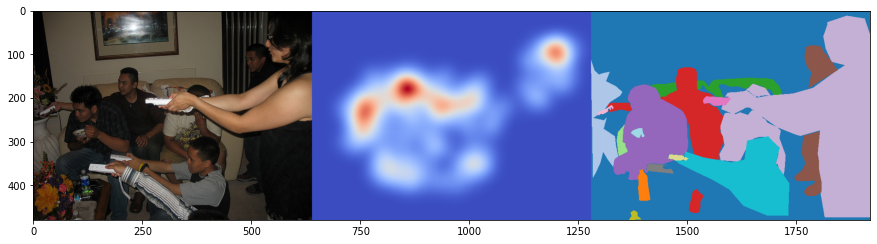

In [181]:
img_id = 97809
train=False

sample_salicon = raw_salicon_segmentation(img_id, train)
plt.imshow(sample_salicon)

In [182]:
coco = train_salicon_coco if train else val_salicon_coco

raw = read_saliency_img(img_id, train)
saliency_map = read_saliency_map(img_id, train)


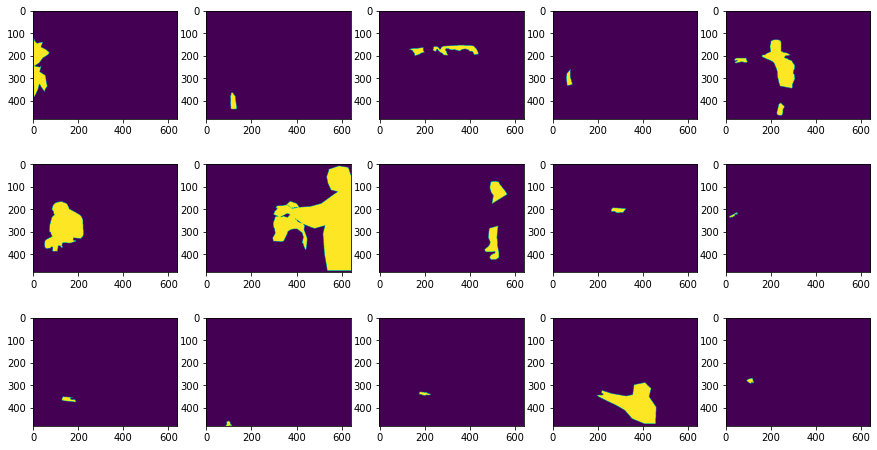

In [184]:
img_info = coco.imgs[img_id]
anns = coco.imgToAnns[img_id]
for i in range(len(anns)):
    obj_mask = val_salicon_coco.annToMask(anns[i])
    if i >= 15: continue
    plt.subplot(3,5,i+1)
    plt.imshow(obj_mask)

Text(0.5, 1.0, 'Masked')

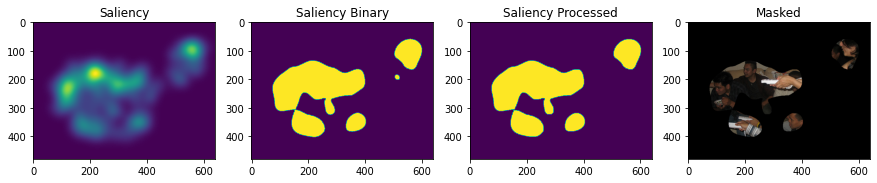

In [187]:
# Threshold ?
_, saliency_binary = cv2.threshold(saliency_map, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((5,5),np.uint8)
saliency_mask = cv2.erode(saliency_binary,kernel,iterations = 3)
saliency_mask = cv2.dilate(saliency_mask,kernel,iterations = 3)

plt.subplot(1,4,1)
plt.imshow(saliency_map)
plt.title("Saliency")
plt.subplot(1,4,2)
plt.imshow(saliency_binary)
plt.title("Saliency Binary")
plt.subplot(1,4,3)
plt.imshow(saliency_mask)
saliency_masked = cv2.bitwise_and(raw, raw, mask=saliency_mask)
plt.title("Saliency Processed")
plt.subplot(1,4,4)
plt.imshow(saliency_masked)
plt.title("Masked")

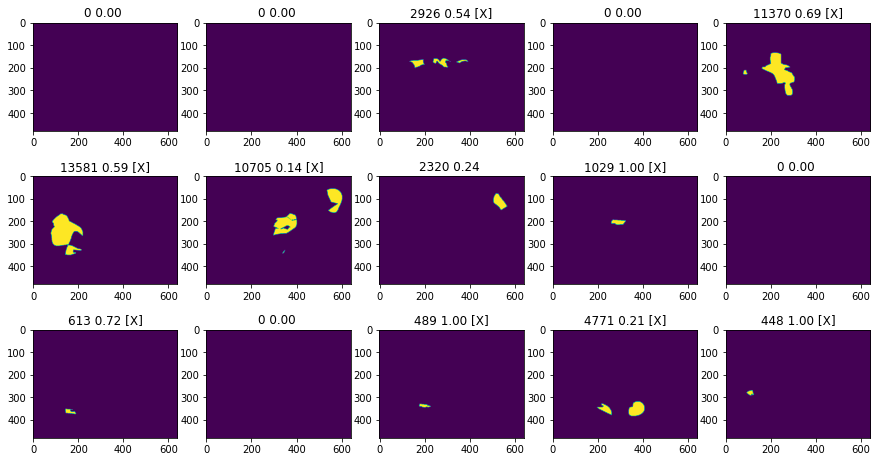

In [190]:
final_mask = np.zeros((480,640), np.uint8)

for i in range(len(anns)):
    obj_mask = val_salicon_coco.annToMask(anns[i])
    intercept = np.multiply(obj_mask, mask)

    obj_area = anns[i]['area']
    intercept_area = intercept.sum()
    ratio = intercept_area/obj_area

    is_save = False
    if intercept_area > 4000 or ratio > 0.5:
        is_save = True
        final_mask = np.maximum(obj_mask, final_mask)

    if i >= 15: continue
    plt.subplot(3,5,i+1)
    plt.title(f"{intercept_area} {ratio:0.2f} {'[X]' if is_save else ''}")
    plt.imshow(intercept)

Text(0.5, 1.0, 'Masked')

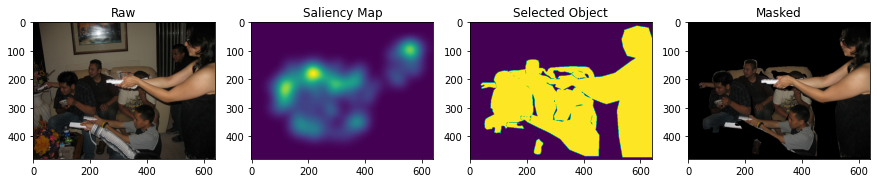

In [193]:
plt.subplot(1,4,1)
plt.imshow(raw)
plt.title("Raw")
plt.subplot(1,4,2)
plt.imshow(saliency_map)
plt.title("Saliency Map")
plt.subplot(1,4,3)
plt.imshow(final_mask)
plt.title("Selected Object")
plt.subplot(1,4,4)
final_masked = cv2.bitwise_and(raw, raw, mask=final_mask)
plt.imshow(final_masked)
plt.title("Masked")

# Data Processing


In [11]:
def generate_obj_mask(img_id: int, train: bool) -> np.ndarray:
    # get saliency
    saliency_map = read_saliency_map(img_id, train)
    _, saliency_binary = cv2.threshold(saliency_map, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((5,5),np.uint8)
    saliency_mask = cv2.erode(saliency_binary,kernel,iterations = 3)
    saliency_mask = cv2.dilate(saliency_mask,kernel,iterations = 3)
    
    # get anno
    coco = train_salicon_coco if train else val_salicon_coco
    img_info = coco.imgs[img_id]
    anns = coco.imgToAnns[img_id]

    # filter anno
    final_mask = np.zeros((img_info['height'],img_info['width']), np.uint8)
    for i in range(len(anns)):
        obj_mask = coco.annToMask(anns[i])
        intercept = np.multiply(obj_mask, saliency_mask)

        obj_area = anns[i]['area']
        intercept_area = intercept.sum()
        ratio = intercept_area/obj_area

        if intercept_area > 4000 or ratio > 0.5:
            final_mask = np.maximum(obj_mask, final_mask)
    return final_mask

In [12]:
def obj_mask_file_name(img_id: int, train: bool) -> str:
    split = "train" if train else "val"
    root = f"../../data/objs/{split}/"
    png = root + f"COCO_{split}2014_{img_id:012d}.png"
    return png

In [206]:
! mkdir -p ../../data/objs/train ../../data/objs/val

In [13]:
## TRAIN
train = True
img_ids = train_salicon_coco.getImgIds()

## VAL
# train = False
# img_ids = val_salicon_coco.getImgIds()

# get finalMask (binary)
for img_id in tqdm(img_ids):
    out_mask = generate_obj_mask(img_id, train)
    out_name = obj_mask_file_name(img_id, train)
    # save to file
    cv2.imwrite(out_name, out_mask * 255)


100%|██████████| 10000/10000 [03:58<00:00, 41.90it/s]


# Test

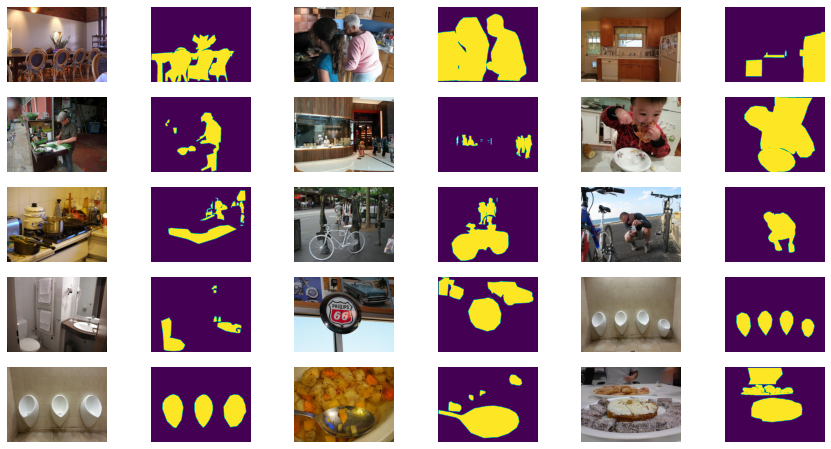

In [16]:
# Show some result
for i, img_id in enumerate(img_ids[0:15]):
    raw = read_saliency_img(img_id, train)
    out_mask = generate_obj_mask(img_id, train)
    plt.subplot(5,6,i*2+1)
    plt.axis('off')
    plt.imshow(raw)
    plt.subplot(5,6,i*2+2)
    plt.axis('off')
    plt.imshow(out_mask)